In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Preprocessing, plotting series

We first load the dataframe and convert into one that is manageable as a time series in python.

            Date  ICCO daily price (US$/tonne)
0     1994-10-03                   1466.240000
1     1994-10-04                   1462.280000
2     1994-10-05                   1430.570000
3     1994-10-06                   1430.320000
4     1994-10-07                   1416.460000
...          ...                           ...
11101 2025-02-23                   8641.286667
11102 2025-02-24                   8408.720000
11103 2025-02-25                   8668.570000
11104 2025-02-26                   9089.950000
11105 2025-02-27                   9099.660000

[11106 rows x 2 columns]


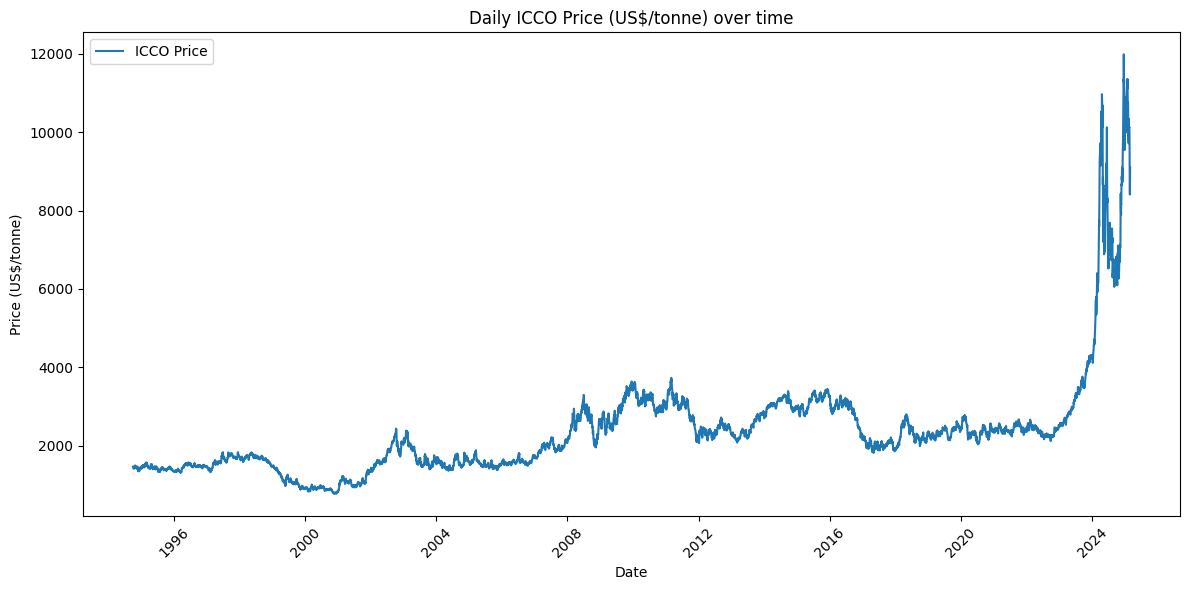

In [ ]:
# Load the Raw Datasets, without preprocessed data.
# Daily_prices_interpolate created via R in STA457_Preprocessing_Submission
df = pd.read_csv('Daily_prices_interpolate.csv')
Ghana_temp_raw = pd.read_csv('Ghana_data.csv')

# Reverse the DataFrame to make it ascending by date.
# df = df.iloc[::-1].reset_index(drop=True)
df['ICCO daily price (US$/tonne)'] = df['ICCO.daily.price..US..tonne.']
# Remove the periods and make sure data is represented as a float
df['ICCO daily price (US$/tonne)'] = df['ICCO daily price (US$/tonne)'].replace({'.': ''}, regex=True).astype(float)

# Convert the "Date" column to datetime (with day-first format)
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['ICCO.daily.price..US..tonne.'])

print(df)

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], linestyle='-', label='ICCO Price')
plt.title('Daily ICCO Price (US$/tonne) over time')
plt.xlabel('Date')
plt.ylabel('Price (US$/tonne)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Split data into cross validation pairs for training and testing LSTM models

Training set shape (Date < 2025-01-01): (11048, 2)
Test set shape (Date >= 2025-01-01): (58, 2)


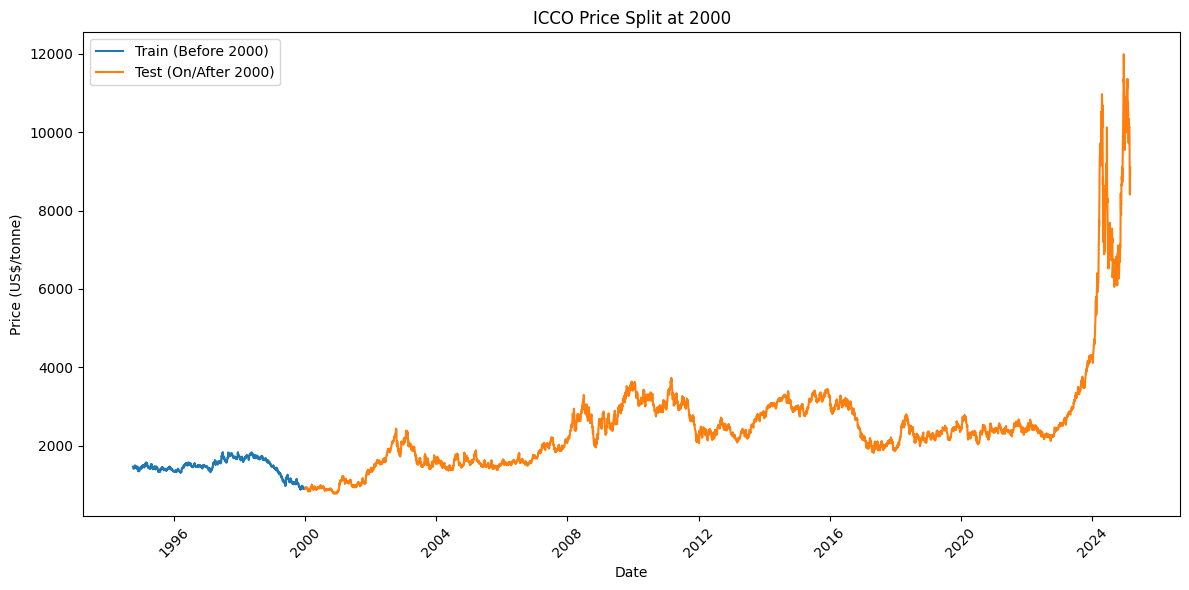

In [ ]:
# Define cut off dates
cutoff_2000 = 2000
cutoff_date_2000 = pd.to_datetime(str(cutoff_2000))

cutoff_2010 = 2010
cutoff_date_2010 = pd.to_datetime(str(cutoff_2010))

cutoff_2020 = 2020
cutoff_date_2020 = pd.to_datetime(str(cutoff_2020))

cutoff_2024 = 2024
cutoff_date_2024 = pd.to_datetime(str(cutoff_2024))

cutoff_2025 = 2025
cutoff_date_2025 = pd.to_datetime(str(cutoff_2025))

# Split the DataFrame into training and test sets.
# Training: All data before the cutoff_date.
# Test: All data on or after the cutoff_date.
train_df_2000 = df[df['Date'] < cutoff_date_2000].copy()
test_df_2000 = df[df['Date'] >= cutoff_date_2000].copy()

train_df_2010 = df[df['Date'] < cutoff_date_2010].copy()
test_df_2010 = df[df['Date'] >= cutoff_date_2010].copy()

train_df_2020 = df[df['Date'] < cutoff_date_2020].copy()
test_df_2020 = df[df['Date'] >= cutoff_date_2020].copy()

train_df_2024 = df[df['Date'] < cutoff_date_2024].copy()
test_df_2024 = df[df['Date'] >= cutoff_date_2024].copy()

train_df_2025 = df[df['Date'] < cutoff_date_2025].copy()
test_df_2025 = df[df['Date'] >= cutoff_date_2025].copy()

# Print the shape of each split to verify.
print(f"Training set shape (Date < {cutoff_date_2025.date()}): {train_df_2025.shape}")
print(f"Test set shape (Date >= {cutoff_date_2025.date()}): {test_df_2025.shape}")

# Plot the split for visual confirmation.
plt.figure(figsize=(12, 6))
plt.plot(train_df_2000['Date'], train_df_2000['ICCO daily price (US$/tonne)'], label=f"Train (Before {cutoff_2000})")
plt.plot(test_df_2000['Date'], test_df_2000['ICCO daily price (US$/tonne)'], label=f"Test (On/After {cutoff_2000})")
plt.title(f"ICCO Price Split at {cutoff_2000}")
plt.xlabel("Date")
plt.ylabel("Price (US$/tonne)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# LSTM one-step ahead predictor with only the price data

Epoch 1/30, Loss: 0.001900
Epoch 2/30, Loss: 0.000136
Epoch 3/30, Loss: 0.000145
Epoch 4/30, Loss: 0.000093
Epoch 5/30, Loss: 0.000088
Epoch 6/30, Loss: 0.000078
Epoch 7/30, Loss: 0.000061
Epoch 8/30, Loss: 0.000058
Epoch 9/30, Loss: 0.000058
Epoch 10/30, Loss: 0.000045
Epoch 11/30, Loss: 0.000040
Epoch 12/30, Loss: 0.000045
Epoch 13/30, Loss: 0.000178
Epoch 14/30, Loss: 0.000034
Epoch 15/30, Loss: 0.000045
Epoch 16/30, Loss: 0.000042
Epoch 17/30, Loss: 0.000051
Epoch 18/30, Loss: 0.000038
Epoch 19/30, Loss: 0.000035
Epoch 20/30, Loss: 0.000036
Epoch 21/30, Loss: 0.000033
Epoch 22/30, Loss: 0.000033
Epoch 23/30, Loss: 0.000040
Epoch 24/30, Loss: 0.000037
Epoch 25/30, Loss: 0.000036
Epoch 26/30, Loss: 0.000034
Epoch 27/30, Loss: 0.000041
Epoch 28/30, Loss: 0.000044
Epoch 29/30, Loss: 0.000041
Epoch 30/30, Loss: 0.000052


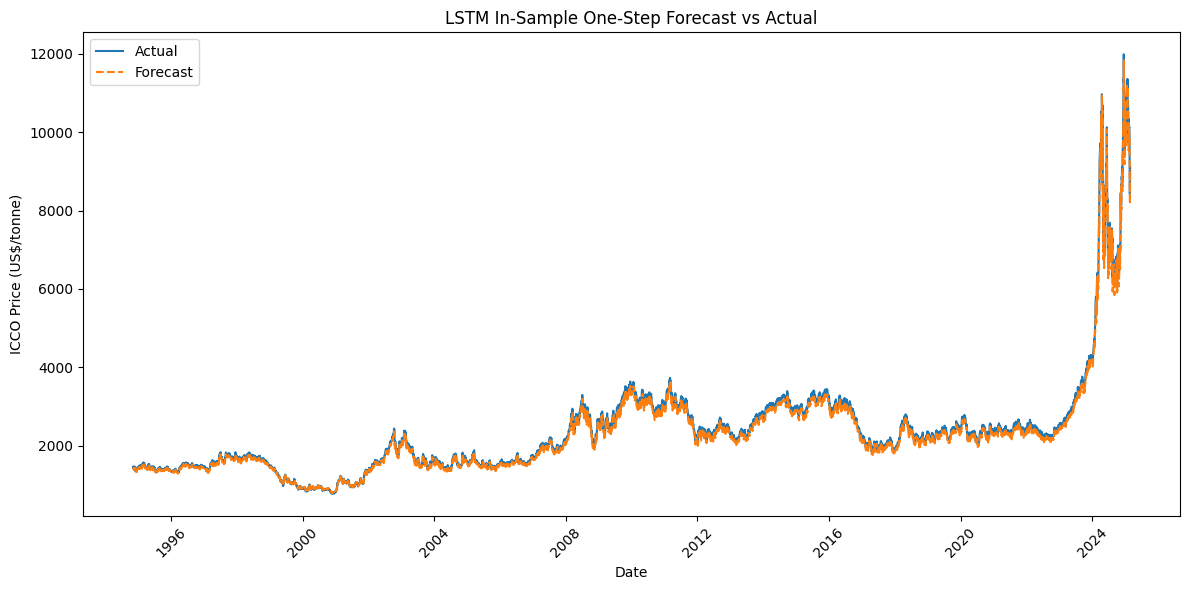

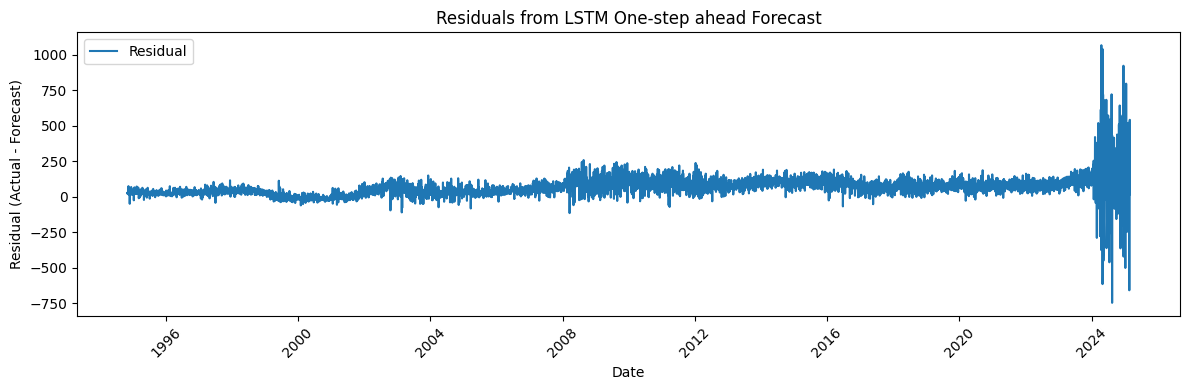

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Normalize the Data
# Use MinMaxScaler to scale the prices to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
price_values = df['ICCO daily price (US$/tonne)'].values.reshape(-1, 1)
price_scaled = scaler.fit_transform(price_values)


# Create Sequences for LSTM
# For one-step forecasting: each sample consists of a window of seq_length values,
# with the target being the next value.
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 30  # use 30 days of past data to predict the next day
X, y = create_sequences(price_scaled, seq_length)

# Convert to PyTorch tensors.
# X_tensor shape: (num_samples, seq_length, 1) and y_tensor shape: (num_samples, 1)
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Create a dataset and DataLoader.
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM.
        out, _ = self.lstm(x, (h0, c0))
        # Use output from the last time step.
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters.
input_size = 1
hidden_size = 30
num_layers = 2
output_size = 1
num_epochs = 30
learning_rate = 0.005

# Instantiate the model, loss function, and optimizer.
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the Model
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")


# Generate In-Sample Forecasts & Compute Residuals
# Use the trained model to produce one-step ahead forecasts for all sliding windows.
model.eval()
with torch.no_grad():
    predictions_tensor = model(X_tensor)  # shape: (num_samples, 1)

# Convert predictions and actual values from tensors to numpy arrays.
predictions = predictions_tensor.squeeze().numpy()  # normalized predictions
actual_normalized = y_tensor.squeeze().numpy()        # normalized actual values

# Invert the scaling to get back to the original price scale.
predictions_inversed = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()
actual_inversed = scaler.inverse_transform(actual_normalized.reshape(-1, 1)).squeeze()

# Align the predictions with their corresponding dates.
forecast_dates = df['Date'].iloc[seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': actual_inversed,
    'Forecast': predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Plot Forecast vs Actual and the Residuals
# Plot the actual series and the LSTM forecasts.
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('LSTM In-Sample One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the residuals.
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Residuals from LSTM One-step ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Ljung-Box Plot and the Normal QQ plot for the LSTM prediction residuals

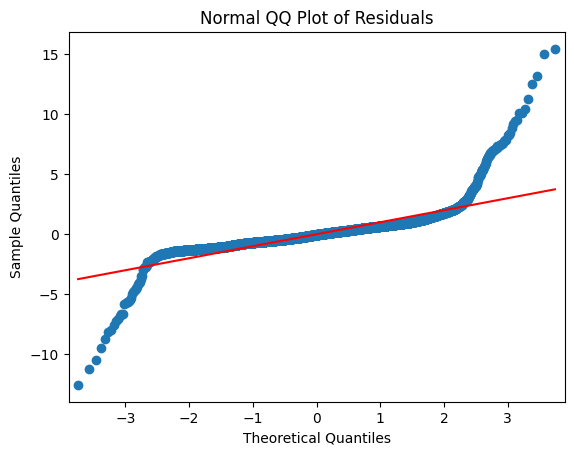

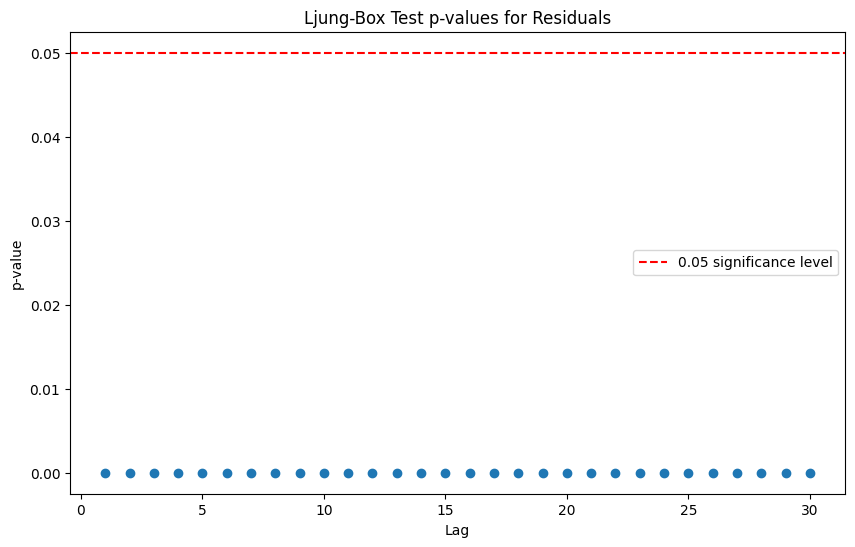

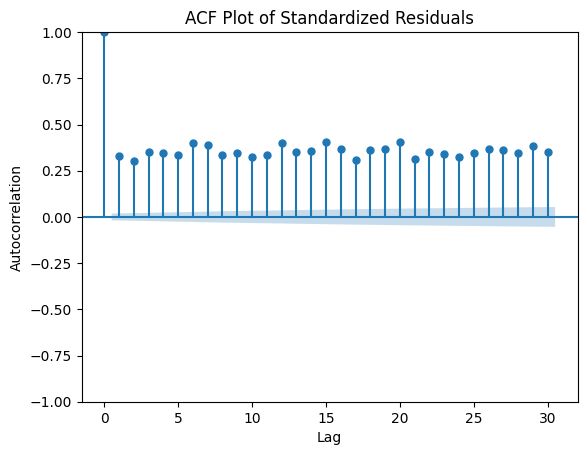

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals as a numpy array.
residuals = results_df['Residual'].values
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Normal QQ Plot
sm.qqplot(std_residuals, line='s')
plt.title('Normal QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Ljung-Box Plot
lags = np.arange(1, 31)
lb_results = acorr_ljungbox(std_residuals, lags=lags, return_df=True)

# Plot the p-values from the Ljung-Box test.
plt.figure(figsize=(10, 6))
plt.stem(lb_results.index, lb_results['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test p-values for Residuals')
plt.legend()
plt.show()

# Plot ACF for lags up to 30
plot_acf(std_residuals, lags=30)
plt.title('ACF Plot of Standardized Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Cross Validated performance with different segments of the data

Epoch 1/50, Loss: 0.013268
Epoch 2/50, Loss: 0.000261
Epoch 3/50, Loss: 0.000223
Epoch 4/50, Loss: 0.000221
Epoch 5/50, Loss: 0.000171
Epoch 6/50, Loss: 0.000167
Epoch 7/50, Loss: 0.000145
Epoch 8/50, Loss: 0.000124
Epoch 9/50, Loss: 0.000127
Epoch 10/50, Loss: 0.000109
Epoch 11/50, Loss: 0.000133
Epoch 12/50, Loss: 0.000102
Epoch 13/50, Loss: 0.000096
Epoch 14/50, Loss: 0.000097
Epoch 15/50, Loss: 0.000082
Epoch 16/50, Loss: 0.000077
Epoch 17/50, Loss: 0.000095
Epoch 18/50, Loss: 0.000075
Epoch 19/50, Loss: 0.000072
Epoch 20/50, Loss: 0.000091
Epoch 21/50, Loss: 0.000066
Epoch 22/50, Loss: 0.000076
Epoch 23/50, Loss: 0.000078
Epoch 24/50, Loss: 0.000065
Epoch 25/50, Loss: 0.000072
Epoch 26/50, Loss: 0.000075
Epoch 27/50, Loss: 0.000089
Epoch 28/50, Loss: 0.000083
Epoch 29/50, Loss: 0.000065
Epoch 30/50, Loss: 0.000071
Epoch 31/50, Loss: 0.000077
Epoch 32/50, Loss: 0.000085
Epoch 33/50, Loss: 0.000064
Epoch 34/50, Loss: 0.000075
Epoch 35/50, Loss: 0.000077
Epoch 36/50, Loss: 0.000071
E

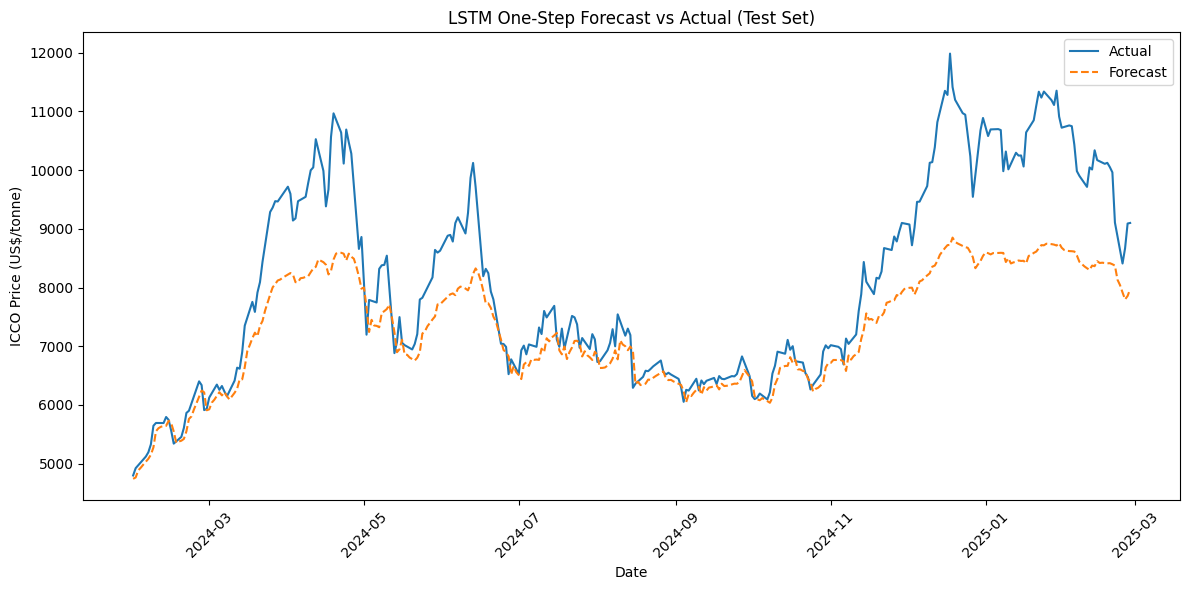

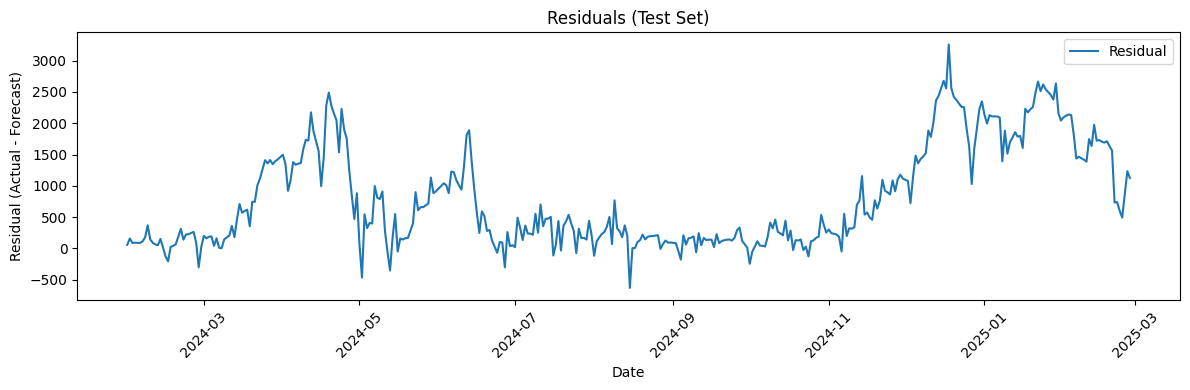

In [ ]:
# Training up to 2024 and testing for after 2024

# Extract the price values for training
train_price_values = train_df_2024['ICCO daily price (US$/tonne)'].values.reshape(-1, 1)

# Fit the scaler on the train set only
scaler = MinMaxScaler(feature_range=(0, 1))
train_price_scaled = scaler.fit_transform(train_price_values)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

# Choose your sequence length
seq_length = 30

# Create sequences out of the scaled train data
X_train, y_train = create_sequences(train_price_scaled, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Create a PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Use the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 30
num_layers = 2
output_size = 1
num_epochs = 50
learning_rate = 0.005

# Instantiate model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

test_price_values = test_df_2024['ICCO daily price (US$/tonne)'].values.reshape(-1, 1)
test_price_scaled = scaler.transform(test_price_values)

X_test, y_test = create_sequences(test_price_scaled, seq_length)

# Convert to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

model.eval()
with torch.no_grad():
    test_predictions_tensor = model(X_test_tensor)

test_predictions = test_predictions_tensor.squeeze().numpy()   # normalized predictions
actual_test_normalized = y_test_tensor.squeeze().numpy()       # normalized actual values

test_predictions_inversed = scaler.inverse_transform(test_predictions.reshape(-1, 1)).squeeze()
actual_test_inversed = scaler.inverse_transform(actual_test_normalized.reshape(-1, 1)).squeeze()

# Align the predictions with their corresponding dates in the test set
forecast_dates_test = test_df_2024['Date'].iloc[seq_length:].reset_index(drop=True)
results_test_df = pd.DataFrame({
    'Date': forecast_dates_test,
    'Actual': actual_test_inversed,
    'Forecast': test_predictions_inversed
})
results_test_df['Residual'] = results_test_df['Actual'] - results_test_df['Forecast']

plt.figure(figsize=(12, 6))
plt.plot(results_test_df['Date'], results_test_df['Actual'], label='Actual')
plt.plot(results_test_df['Date'], results_test_df['Forecast'], label='Forecast', linestyle='--')
plt.title('LSTM One-Step Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 4))
plt.plot(results_test_df['Date'], results_test_df['Residual'], label='Residual')
plt.title('Residuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/50, Loss: 0.002900
Epoch 2/50, Loss: 0.000224
Epoch 3/50, Loss: 0.000198
Epoch 4/50, Loss: 0.000152
Epoch 5/50, Loss: 0.000113
Epoch 6/50, Loss: 0.000096
Epoch 7/50, Loss: 0.000116
Epoch 8/50, Loss: 0.000105
Epoch 9/50, Loss: 0.000077
Epoch 10/50, Loss: 0.000075
Epoch 11/50, Loss: 0.000081
Epoch 12/50, Loss: 0.000106
Epoch 13/50, Loss: 0.000064
Epoch 14/50, Loss: 0.000058
Epoch 15/50, Loss: 0.000076
Epoch 16/50, Loss: 0.000058
Epoch 17/50, Loss: 0.000067
Epoch 18/50, Loss: 0.000058
Epoch 19/50, Loss: 0.000069
Epoch 20/50, Loss: 0.000070
Epoch 21/50, Loss: 0.000056
Epoch 22/50, Loss: 0.000061
Epoch 23/50, Loss: 0.000057
Epoch 24/50, Loss: 0.000058
Epoch 25/50, Loss: 0.000061
Epoch 26/50, Loss: 0.000057
Epoch 27/50, Loss: 0.000062
Epoch 28/50, Loss: 0.000078
Epoch 29/50, Loss: 0.000081
Epoch 30/50, Loss: 0.000076
Epoch 31/50, Loss: 0.000074
Epoch 32/50, Loss: 0.000073
Epoch 33/50, Loss: 0.000058
Epoch 34/50, Loss: 0.000083
Epoch 35/50, Loss: 0.000056
Epoch 36/50, Loss: 0.000049
E

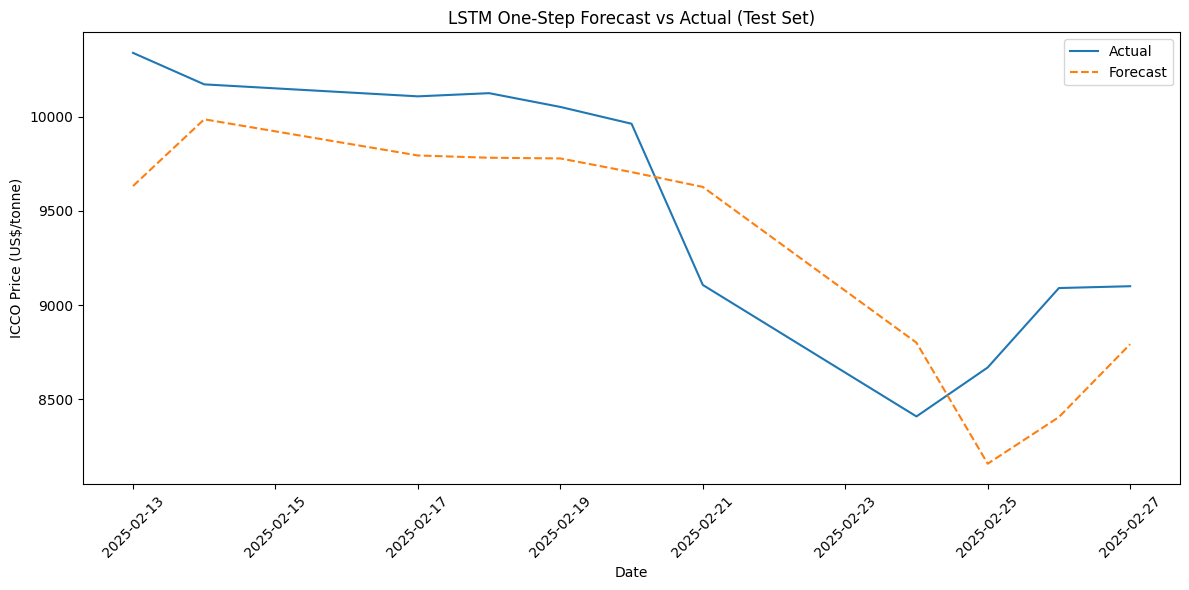

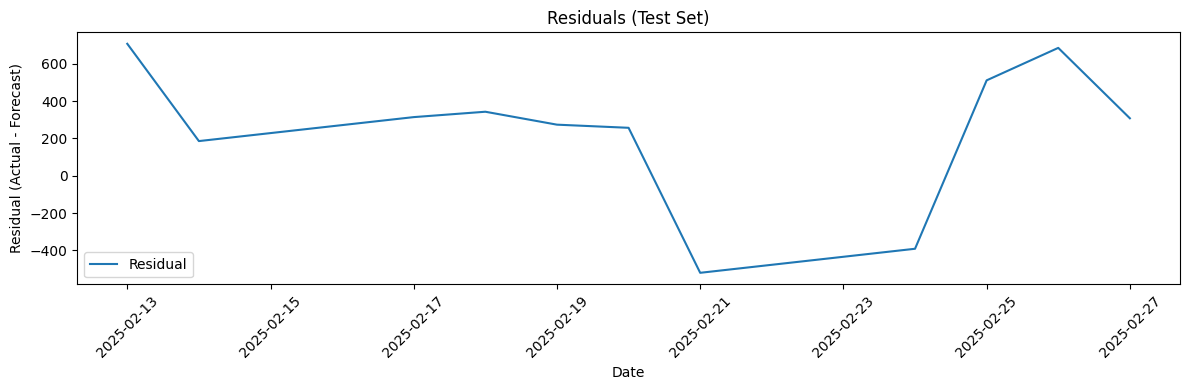

In [ ]:
# Training up to 2025 and testing for after 2025

# Extract the price values for training
train_price_values = train_df_2025['ICCO daily price (US$/tonne)'].values.reshape(-1, 1)

# Fit the scaler on the train set only
scaler = MinMaxScaler(feature_range=(0, 1))
train_price_scaled = scaler.fit_transform(train_price_values)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

# Choose your sequence length
seq_length = 30

# Create sequences out of the scaled train data
X_train, y_train = create_sequences(train_price_scaled, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Create a PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Use the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 30
num_layers = 2
output_size = 1
num_epochs = 50
learning_rate = 0.005

# Instantiate model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

test_price_values = test_df_2025['ICCO daily price (US$/tonne)'].values.reshape(-1, 1)
test_price_scaled = scaler.transform(test_price_values)

X_test, y_test = create_sequences(test_price_scaled, seq_length)

# Convert to PyTorch tensors
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

model.eval()
with torch.no_grad():
    test_predictions_tensor = model(X_test_tensor)

test_predictions = test_predictions_tensor.squeeze().numpy()   # normalized predictions
actual_test_normalized = y_test_tensor.squeeze().numpy()       # normalized actual values

test_predictions_inversed = scaler.inverse_transform(test_predictions.reshape(-1, 1)).squeeze()
actual_test_inversed = scaler.inverse_transform(actual_test_normalized.reshape(-1, 1)).squeeze()

# Align the predictions with their corresponding dates in the test set
forecast_dates_test = test_df_2025['Date'].iloc[seq_length:].reset_index(drop=True)
results_test_df = pd.DataFrame({
    'Date': forecast_dates_test,
    'Actual': actual_test_inversed,
    'Forecast': test_predictions_inversed
})
results_test_df['Residual'] = results_test_df['Actual'] - results_test_df['Forecast']

plt.figure(figsize=(12, 6))
plt.plot(results_test_df['Date'], results_test_df['Actual'], label='Actual')
plt.plot(results_test_df['Date'], results_test_df['Forecast'], label='Forecast', linestyle='--')
plt.title('LSTM One-Step Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 4))
plt.plot(results_test_df['Date'], results_test_df['Residual'], label='Residual')
plt.title('Residuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# We will also attempt to use monthly prices to better drain out the variance between the mismatch in dates, and in the process use past temperature and precipitation data in Ghana for multivariate LSTM forecasting.

In [ ]:
# Load monthly data, month: 'YearMonth'
# csv files for monthly data created via Rin STA457_Preprocessing_Submission.Rmd
monthly_prices = pd.read_csv('cocoa_monthly.csv') # Variable of importance: 'MeanPrice'
ghana_data = pd.read_csv('ghana_monthly.csv') # Variables of importance: 'TotalPRCP', 'MeanTAVG', 'MeanTMAX', 'MeanTMIN'

print(monthly_prices)
print(ghana_data)
ghana_data.info()

      YearMonth     avg_price
0    1994-10-01   1447.960952
1    1994-11-01   1436.980455
2    1994-12-01   1399.390476
3    1995-01-01   1468.818095
4    1995-02-01   1510.437500
..          ...           ...
360  2024-10-01   6582.857391
361  2024-11-01   7930.125238
362  2024-12-01  10353.047143
363  2025-01-01  10709.305455
364  2025-02-01   9827.304211

[365 rows x 2 columns]
      YearMonth  TotalPRCP   MeanTAVG   MeanTMAX   MeanTMIN
0    1990-01-01       0.39  81.484848  90.200000  75.541667
1    1990-02-01       2.14  81.735294  90.916667  75.111111
2    1990-03-01       3.15  84.489362  94.782609  76.666667
3    1990-04-01      12.68  81.863636  91.933333  74.482759
4    1990-05-01       8.09  80.884058  89.448276  74.240741
..          ...        ...        ...        ...        ...
411  2024-07-01      14.66  78.804124  84.534413  73.568182
412  2024-08-01      10.37  77.479452  83.322581  72.189655
413  2024-09-01       8.44  79.042105  86.824034  72.689498
414  2024-10-01 

Epoch 1/300, Loss: 0.063629
Epoch 2/300, Loss: 0.027911
Epoch 3/300, Loss: 0.020792
Epoch 4/300, Loss: 0.016716
Epoch 5/300, Loss: 0.015975
Epoch 6/300, Loss: 0.012803
Epoch 7/300, Loss: 0.007964
Epoch 8/300, Loss: 0.004178
Epoch 9/300, Loss: 0.002980
Epoch 10/300, Loss: 0.002916
Epoch 11/300, Loss: 0.002758
Epoch 12/300, Loss: 0.002529
Epoch 13/300, Loss: 0.002491
Epoch 14/300, Loss: 0.002471
Epoch 15/300, Loss: 0.002409
Epoch 16/300, Loss: 0.002492
Epoch 17/300, Loss: 0.002292
Epoch 18/300, Loss: 0.002572
Epoch 19/300, Loss: 0.003132
Epoch 20/300, Loss: 0.002540
Epoch 21/300, Loss: 0.002273
Epoch 22/300, Loss: 0.002243
Epoch 23/300, Loss: 0.002116
Epoch 24/300, Loss: 0.002665
Epoch 25/300, Loss: 0.002361
Epoch 26/300, Loss: 0.002087
Epoch 27/300, Loss: 0.002140
Epoch 28/300, Loss: 0.001907
Epoch 29/300, Loss: 0.001956
Epoch 30/300, Loss: 0.002227
Epoch 31/300, Loss: 0.002280
Epoch 32/300, Loss: 0.002131
Epoch 33/300, Loss: 0.001896
Epoch 34/300, Loss: 0.002579
Epoch 35/300, Loss: 0.0

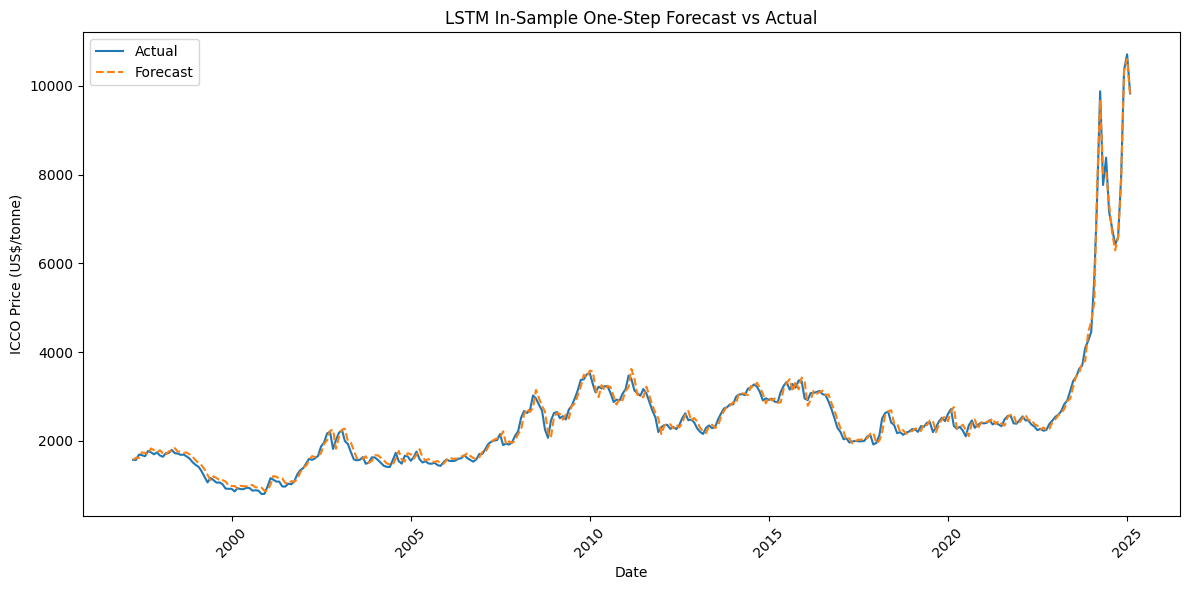

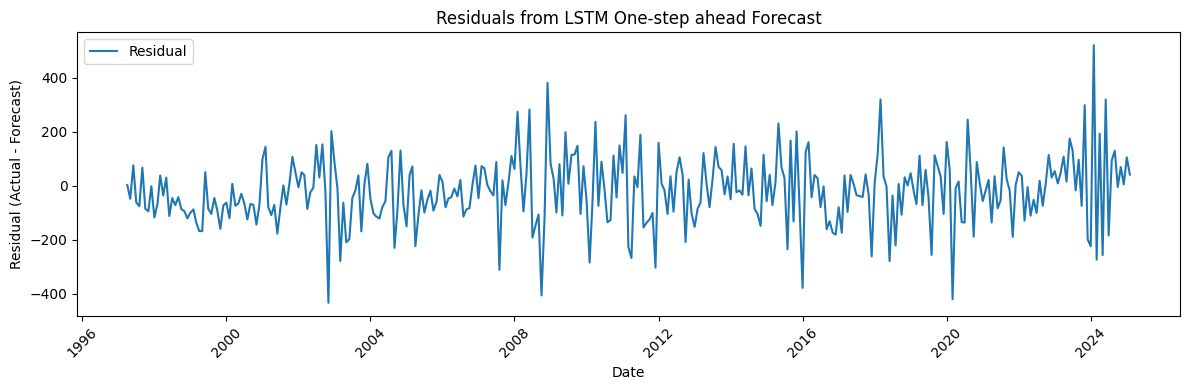

In [ ]:
# Try LSTM with monthly data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Normalize the Data
# Use MinMaxScaler to scale the prices to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
price_values = monthly_prices['avg_price'].values.reshape(-1, 1)
price_scaled = scaler.fit_transform(price_values)

# Create Sequences for LSTM
# For one-step forecasting: each sample consists of a window of seq_length values,
# with the target being the next value.
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 30  # use 30 days of past data to predict the next day
X, y = create_sequences(price_scaled, seq_length)

# Convert to PyTorch tensors.
# X_tensor shape: (num_samples, seq_length, 1) and y_tensor shape: (num_samples, 1)
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Create a dataset and DataLoader.
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM.
        out, _ = self.lstm(x, (h0, c0))
        # Use output from the last time step.
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters.
input_size = 1
hidden_size = 30
num_layers = 2
output_size = 1
num_epochs = 300
learning_rate = 0.005

# Instantiate the model, loss function, and optimizer.
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the Model
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")


# Generate In-Sample Forecasts & Compute Residuals
# Use the trained model to produce one-step ahead forecasts for all sliding windows.
model.eval()
with torch.no_grad():
    predictions_tensor = model(X_tensor)  # shape: (num_samples, 1)

# Convert predictions and actual values from tensors to numpy arrays.
predictions = predictions_tensor.squeeze().numpy()  # normalized predictions
actual_normalized = y_tensor.squeeze().numpy()        # normalized actual values

# Invert the scaling to get back to the original price scale.
predictions_inversed = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()
actual_inversed = scaler.inverse_transform(actual_normalized.reshape(-1, 1)).squeeze()

# Align the predictions with their corresponding dates.
# The first forecast corresponds to the date at index seq_length.
forecast_dates = monthly_prices['YearMonth'].iloc[seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': actual_inversed,
    'Forecast': predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Convert your 'Date' column to a datetime type
results_df['Date'] = pd.to_datetime(results_df['Date'])

# Plot your data using the Date as the x-axis
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')

plt.title('LSTM In-Sample One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')

# Use a major locator to show ticks every 5 years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))        # tick every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))      # format tick labels as 'YYYY'

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the residuals.
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Residuals from LSTM One-step ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

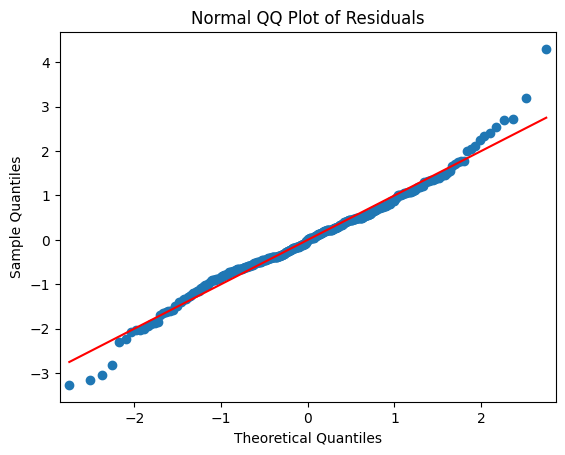

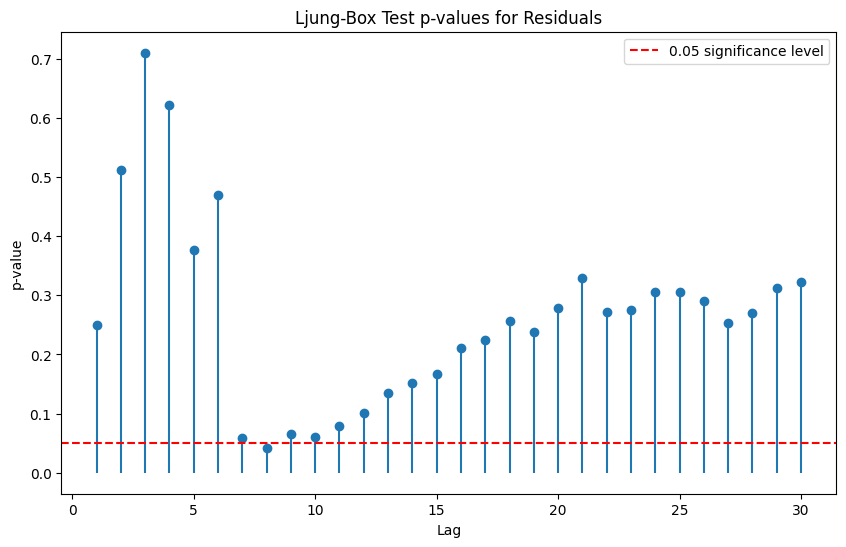

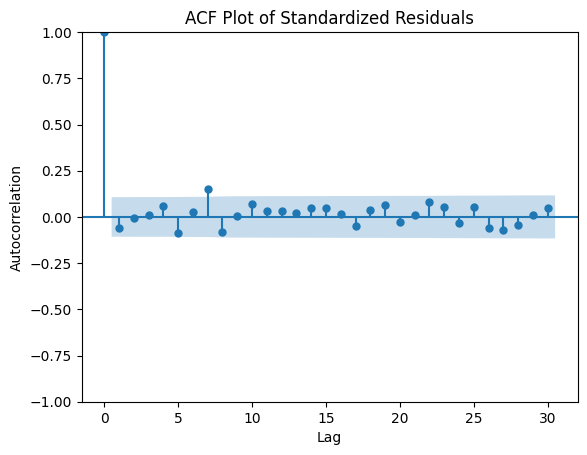

In [ ]:
 # Residual Analysis for monthly univariate LSTM

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals as a numpy array.
residuals = results_df['Residual'].values
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Normal QQ Plot
sm.qqplot(std_residuals, line='s')
plt.title('Normal QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Ljung-Box Plot
# The Ljung-Box test evaluates the null hypothesis that the residuals are uncorrelated.
# We can compute the test statistics and p-values for a range of lags.
# Here, we compute them for lags 1 to 30.
lags = np.arange(1, 31)
lb_results = acorr_ljungbox(std_residuals, lags=lags, return_df=True)

# Plot the p-values from the Ljung-Box test.
plt.figure(figsize=(10, 6))
plt.stem(lb_results.index, lb_results['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test p-values for Residuals')
plt.legend()
plt.show()

# Plot ACF for lags up to 30
plot_acf(std_residuals, lags=30)
plt.title('ACF Plot of Standardized Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# 2. Multivariate LSTM architectures for monthly data, with mean temperature 6 months prior and total precipitation 44 months prior.

In [ ]:
# Convert to datetime and sort
monthly_prices['YearMonth'] = pd.to_datetime(monthly_prices['YearMonth'])
ghana_data['YearMonth'] = pd.to_datetime(ghana_data['YearMonth'])

monthly_prices.sort_values('YearMonth', inplace=True)
ghana_data.sort_values('YearMonth', inplace=True)

# Create new columns in monthly_prices with the lagged dates:
monthly_prices['lag_date_temp'] = monthly_prices['YearMonth'] - pd.DateOffset(months=6)
monthly_prices['lag_date_prcp'] = monthly_prices['YearMonth'] - pd.DateOffset(months=44)

# Merge to get temperature from 6 months ago:
df_tavg = pd.merge(
    monthly_prices,
    ghana_data[['YearMonth', 'MeanTAVG']],
    left_on='lag_date_temp',  # match lagged date with ghana_data's YearMonth
    right_on='YearMonth',
    how='left'
)
# Rename the column and remove extra columns:
df_tavg.rename(columns={'MeanTAVG': 'MeanTAVG_lag6'}, inplace=True)
df_tavg.drop(columns=['lag_date_temp', 'YearMonth_y'], inplace=True, errors='ignore')
# Drop rows where lagged temperature is missing
df_tavg.dropna(subset=['MeanTAVG_lag6'], inplace=True)
df_tavg.rename(columns={'YearMonth_x': 'YearMonth'}, inplace=True)

# Merge to get precipitation from 44 months ago:
df_prcp = pd.merge(
    monthly_prices,
    ghana_data[['YearMonth', 'TotalPRCP']],
    left_on='lag_date_prcp',  # match lagged date with ghana_data's YearMonth
    right_on='YearMonth',
    how='left'
)
# Rename the column and remove extra columns:
df_prcp.rename(columns={'TotalPRCP': 'TotalPRCP_lag44'}, inplace=True)
df_prcp.drop(columns=['lag_date_prcp', 'YearMonth_y'], inplace=True, errors='ignore')
# Drop rows where lagged precipitation is missing
df_prcp.dropna(subset=['TotalPRCP_lag44'], inplace=True)
df_prcp.rename(columns={'YearMonth_x': 'YearMonth'}, inplace=True)

# Print the results
print(df_tavg)
print(df_prcp)

     YearMonth     avg_price lag_date_prcp  MeanTAVG_lag6
0   1994-10-01   1447.960952    1991-02-01      83.014815
1   1994-11-01   1436.980455    1991-03-01      81.390625
2   1994-12-01   1399.390476    1991-04-01      78.500000
3   1995-01-01   1468.818095    1991-05-01      77.047059
4   1995-02-01   1510.437500    1991-06-01      77.294574
..         ...           ...           ...            ...
360 2024-10-01   6582.857391    2021-02-01      84.886447
361 2024-11-01   7930.125238    2021-03-01      83.443636
362 2024-12-01  10353.047143    2021-04-01      81.011152
363 2025-01-01  10709.305455    2021-05-01      78.804124
364 2025-02-01   9827.304211    2021-06-01      77.479452

[362 rows x 4 columns]
     YearMonth     avg_price lag_date_temp  TotalPRCP_lag44
0   1994-10-01   1447.960952    1994-04-01             1.03
1   1994-11-01   1436.980455    1994-05-01             0.24
2   1994-12-01   1399.390476    1994-06-01            13.44
3   1995-01-01   1468.818095    1994-07-

# Multivariate LSTM with average temperature and monthly prices

Epoch 20/300, Loss: 0.002299
Epoch 40/300, Loss: 0.001685
Epoch 60/300, Loss: 0.001013
Epoch 80/300, Loss: 0.000788
Epoch 100/300, Loss: 0.000745
Epoch 120/300, Loss: 0.000513
Epoch 140/300, Loss: 0.000466
Epoch 160/300, Loss: 0.000368
Epoch 180/300, Loss: 0.000388
Epoch 200/300, Loss: 0.000409
Epoch 220/300, Loss: 0.000185
Epoch 240/300, Loss: 0.000183
Epoch 260/300, Loss: 0.000158
Epoch 280/300, Loss: 0.000154
Epoch 300/300, Loss: 0.000171


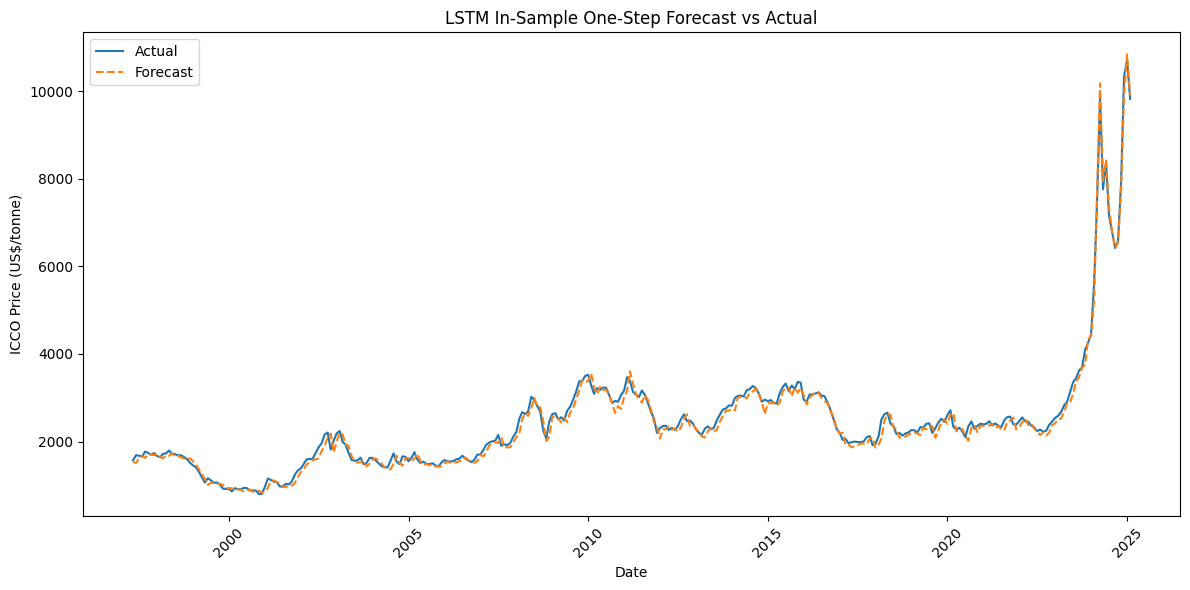

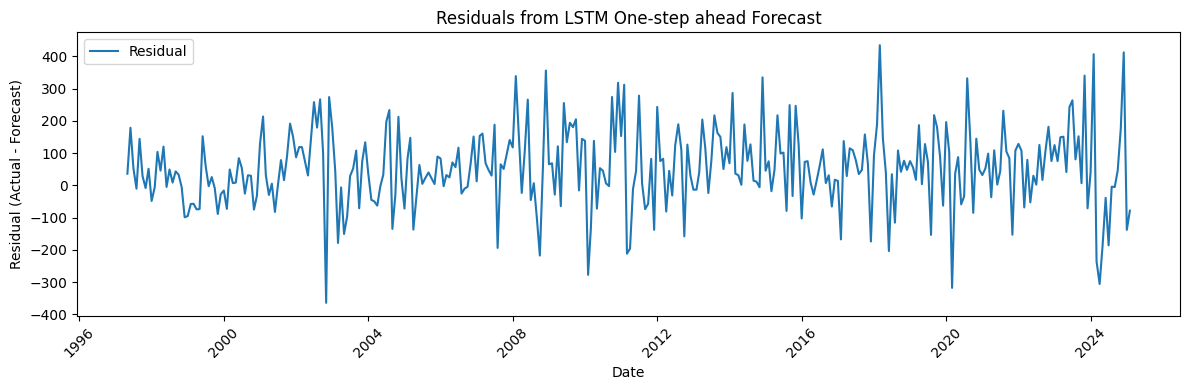

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare data
df_tavg['YearMonth'] = pd.to_datetime(df_tavg['YearMonth'])

data_2d = df_tavg[['avg_price', 'MeanTAVG_lag6']].values

# Scale them together
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_2d)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i : i+seq_length]
        y_val = data[i+seq_length, 0]
        xs.append(x_seq)
        ys.append(y_val)
    X_arr = np.array(xs)
    y_arr = np.array(ys).reshape(-1, 1)
    return X_arr, y_arr

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Convert to torch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # h0, c0 shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # last time step
        return out

model = LSTMModel(input_size=2, hidden_size=30, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train
num_epochs = 300
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# In-sample forecasts
model.eval()
with torch.no_grad():
    predictions_tensor = model(X_tensor)

predictions = predictions_tensor.numpy().squeeze()
actual_norm = y_tensor.numpy().squeeze()

# Invert scaling for price only
pred_2d = np.zeros((len(predictions), 2))
act_2d  = np.zeros((len(actual_norm), 2))

pred_2d[:,0] = predictions
act_2d[:,0]  = actual_norm

pred_inversed_2d = scaler.inverse_transform(pred_2d)
act_inversed_2d  = scaler.inverse_transform(act_2d)

predictions_inversed = pred_inversed_2d[:,0]
actual_inversed      = act_inversed_2d[:,0]

# Align results with dates
forecast_dates = df_tavg['YearMonth'].iloc[seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': actual_inversed,
    'Forecast': predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('LSTM In-Sample One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Residuals from LSTM One-step ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

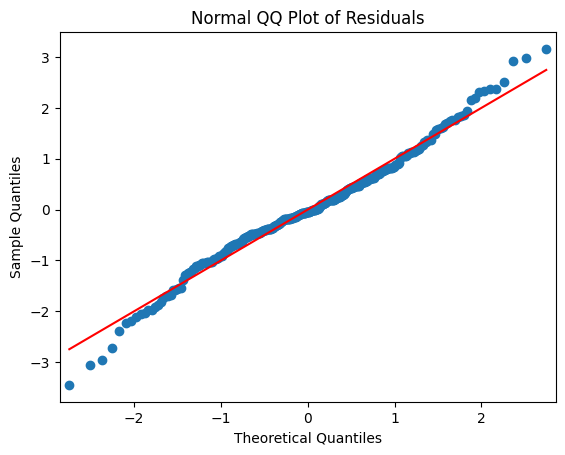

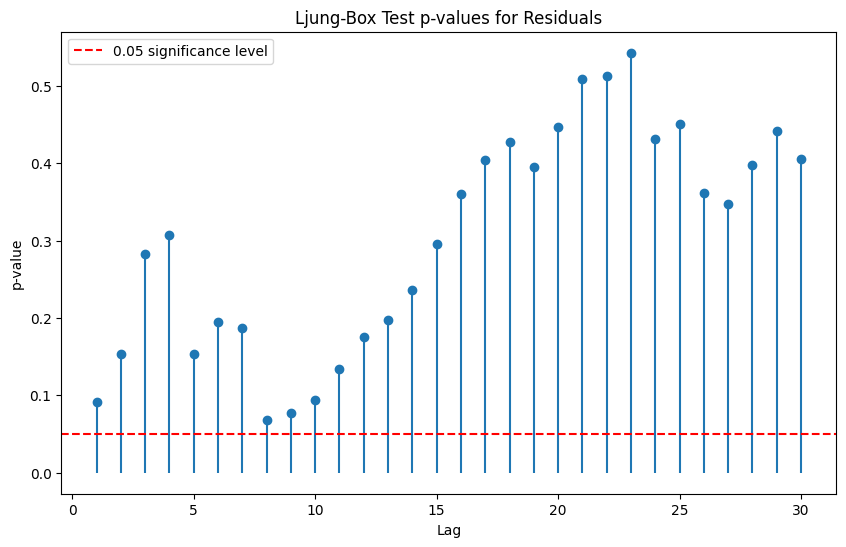

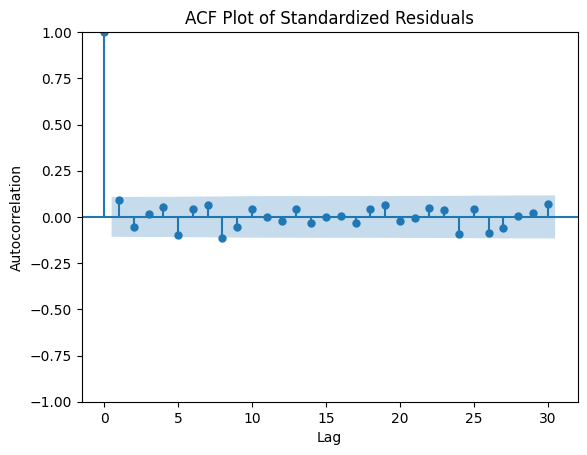

In [ ]:
# Residual Analysis for multivariate LSTM with average temperatures

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals as a numpy array.
residuals = results_df['Residual'].values
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Normal QQ Plot
sm.qqplot(std_residuals, line='s')
plt.title('Normal QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Ljung-Box Plot
lags = np.arange(1, 31)
lb_results = acorr_ljungbox(std_residuals, lags=lags, return_df=True)

# Plot the p-values from the Ljung-Box test.
plt.figure(figsize=(10, 6))
plt.stem(lb_results.index, lb_results['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test p-values for Residuals')
plt.legend()
plt.show()

# Plot ACF for lags up to 30
plot_acf(std_residuals, lags=30)
plt.title('ACF Plot of Standardized Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Multivariate LSTM with Total Precipitation and monthly prices

Epoch 20/300, Loss: 0.002190
Epoch 40/300, Loss: 0.001504
Epoch 60/300, Loss: 0.001041
Epoch 80/300, Loss: 0.000586
Epoch 100/300, Loss: 0.000454
Epoch 120/300, Loss: 0.000306
Epoch 140/300, Loss: 0.000317
Epoch 160/300, Loss: 0.000263
Epoch 180/300, Loss: 0.000227
Epoch 200/300, Loss: 0.000180
Epoch 220/300, Loss: 0.000243
Epoch 240/300, Loss: 0.000248
Epoch 260/300, Loss: 0.000147
Epoch 280/300, Loss: 0.000161
Epoch 300/300, Loss: 0.000149


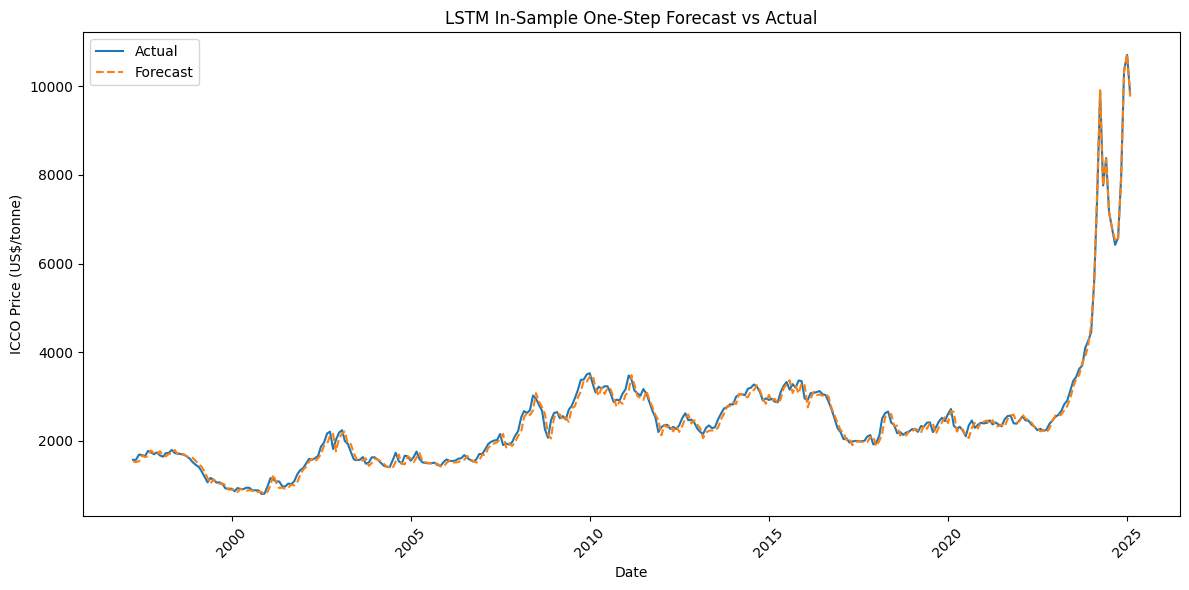

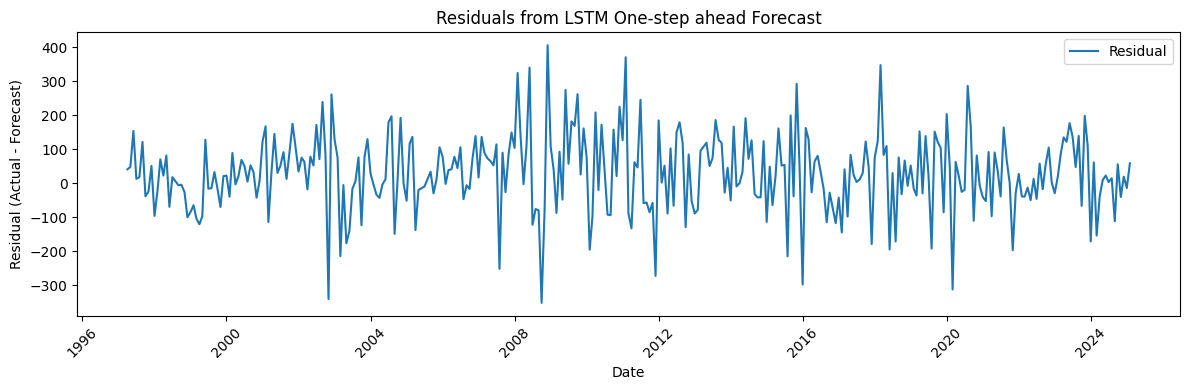

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare data
df_prcp['YearMonth'] = pd.to_datetime(df_prcp['YearMonth'])

data_2d = df_prcp[['avg_price', 'TotalPRCP_lag44']].values

# Scale them together
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_2d)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i : i+seq_length]
        y_val = data[i+seq_length, 0]
        xs.append(x_seq)
        ys.append(y_val)
    X_arr = np.array(xs)
    y_arr = np.array(ys).reshape(-1, 1)
    return X_arr, y_arr

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Convert to torch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # h0, c0 shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=2, hidden_size=30, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train
num_epochs = 300
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# In-sample forecasts
model.eval()
with torch.no_grad():
    predictions_tensor = model(X_tensor)

predictions = predictions_tensor.numpy().squeeze()
actual_norm = y_tensor.numpy().squeeze()

# Invert scaling for price only
pred_2d = np.zeros((len(predictions), 2))
act_2d  = np.zeros((len(actual_norm), 2))

pred_2d[:,0] = predictions
act_2d[:,0]  = actual_norm

pred_inversed_2d = scaler.inverse_transform(pred_2d)
act_inversed_2d  = scaler.inverse_transform(act_2d)

predictions_inversed = pred_inversed_2d[:,0]
actual_inversed      = act_inversed_2d[:,0]

# Align results with dates
forecast_dates = df_prcp['YearMonth'].iloc[seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': actual_inversed,
    'Forecast': predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('LSTM In-Sample One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Residuals from LSTM One-step ahead Forecast')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

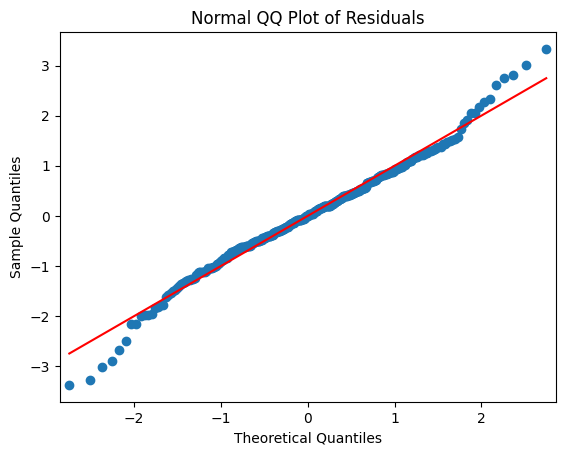

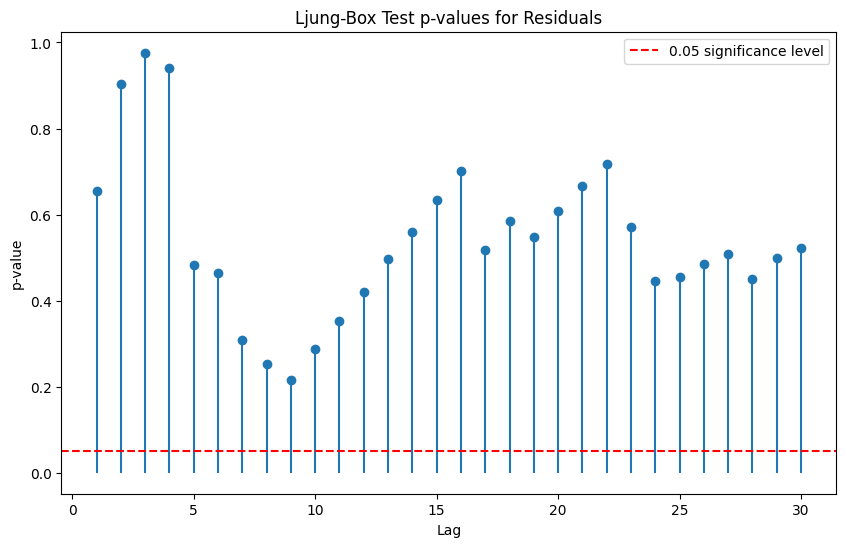

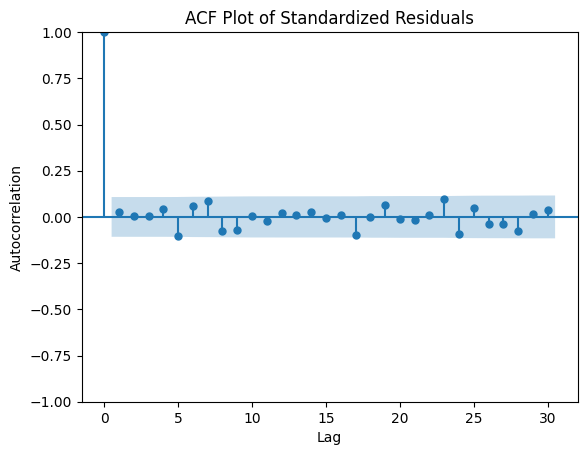

In [ ]:
# Residual Analysis for data for multivariate data with preipitation

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals as a numpy array.
residuals = results_df['Residual'].values
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Normal QQ Plot
sm.qqplot(std_residuals, line='s')
plt.title('Normal QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Ljung-Box Plot
# The Ljung-Box test evaluates the null hypothesis that the residuals are uncorrelated.
# We can compute the test statistics and p-values for a range of lags.
# Here, we compute them for lags 1 to 30.
lags = np.arange(1, 31)
lb_results = acorr_ljungbox(std_residuals, lags=lags, return_df=True)

# Plot the p-values from the Ljung-Box test.
plt.figure(figsize=(10, 6))
plt.stem(lb_results.index, lb_results['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='0.05 significance level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test p-values for Residuals')
plt.legend()
plt.show()

# Plot ACF for lags up to 30
plot_acf(std_residuals, lags=30)
plt.title('ACF Plot of Standardized Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Now that we have found models that satisfies our residual assumptions, we will measure the forecasting performance of this model using a training/test split, of the past 6 months of overlapping data.

In [ ]:
# Define MAPE to implement for our forecasting measurement
def mape(y_true, y_pred):
    """
    Compute the Mean Absolute Percentage Error (MAPE) in percentage.
    y_true and y_pred should be numpy arrays.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by selecting only nonzero actual values.
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Price Series.


Training sequences shape: (329, 30, 1)
Test sequences shape: (6, 30, 1)
Epoch 20/300, Loss: 0.001368
Epoch 40/300, Loss: 0.000831
Epoch 60/300, Loss: 0.001126
Epoch 80/300, Loss: 0.000476
Epoch 100/300, Loss: 0.000679
Epoch 120/300, Loss: 0.000350
Epoch 140/300, Loss: 0.000339
Epoch 160/300, Loss: 0.000281
Epoch 180/300, Loss: 0.000223
Epoch 200/300, Loss: 0.000367
Epoch 220/300, Loss: 0.000351
Epoch 240/300, Loss: 0.000241
Epoch 260/300, Loss: 0.000171
Epoch 280/300, Loss: 0.000168
Epoch 300/300, Loss: 0.000274
Test MAE: 1690.9891322164456
Test RMSE: 2098.8778316584717
Test MAPE: 17.437295209697183


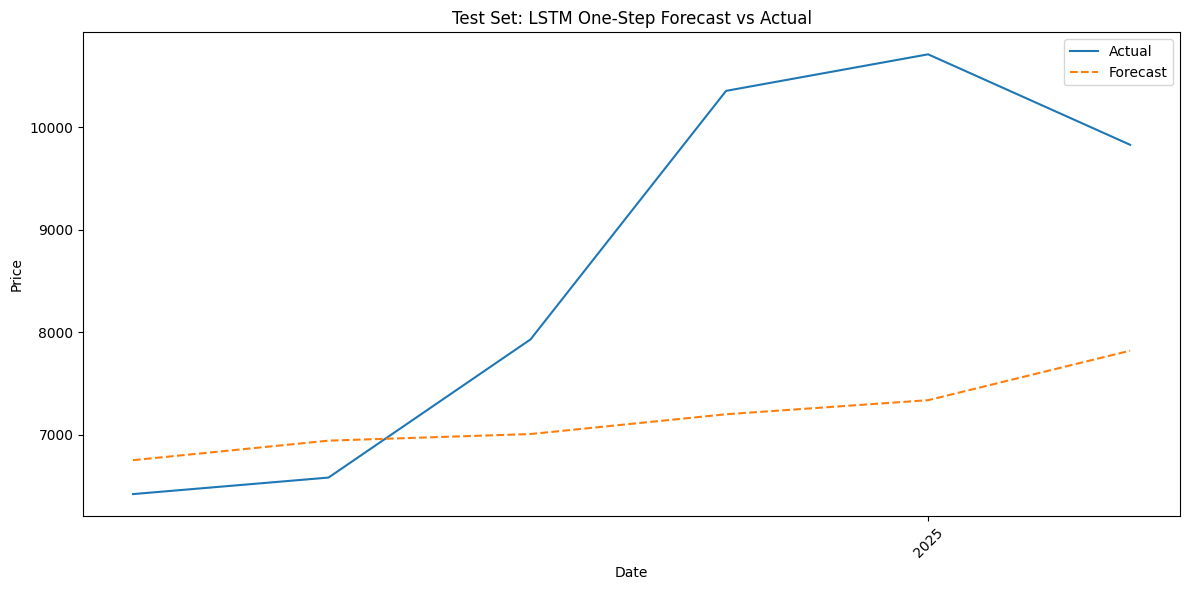

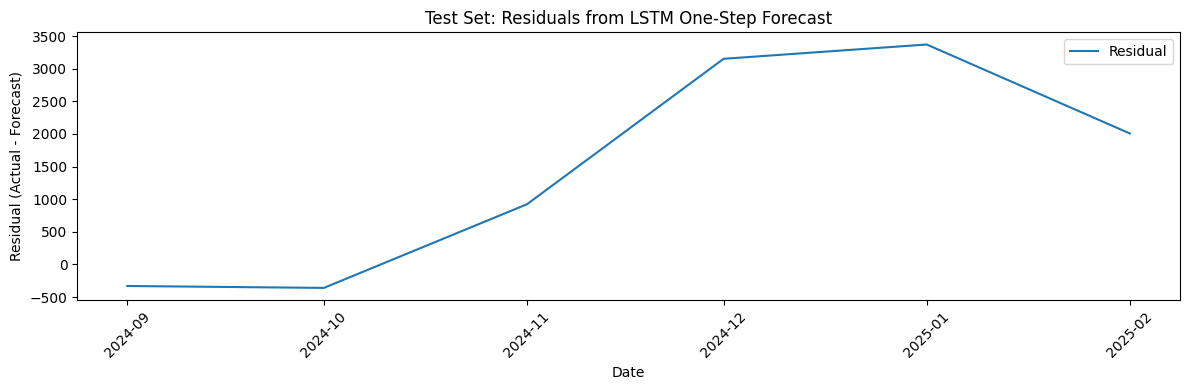

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import metrics


# Extract and scale the price data.
price_values = monthly_prices['avg_price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price_values)

# Create Sequences for LSTM Forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 30  # Use past 30 months to predict the next month.
X, y = create_sequences(price_scaled, seq_length)

# Train/Test Split
# The forecast corresponding to a sequence at index i is for row i+seq_length.
# Reserve the last 6 months for testing (adjusted by seq_length).
m = len(monthly_prices)
split_idx = m - 6 - seq_length

train_X = X[:split_idx]
train_y = y[:split_idx]
test_X  = X[split_idx:]
test_y  = y[split_idx:]

print("Training sequences shape:", train_X.shape)
print("Test sequences shape:", test_X.shape)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        # Use the output from the last time step.
        out = self.fc(out[:, -1, :])
        return out

input_size = 1    # Only one feature: price.
hidden_size = 30
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the Model on the Training Set
train_dataset = TensorDataset(torch.from_numpy(train_X).float(),
                              torch.from_numpy(train_y).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 300
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(train_dataset)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# Evaluate Forecasting Performance on the Test Set
model.eval()
with torch.no_grad():
    test_X_tensor = torch.from_numpy(test_X).float()
    test_predictions_tensor = model(test_X_tensor)

# Convert predictions and true values from tensors to numpy arrays.
test_predictions = test_predictions_tensor.numpy().squeeze()
test_y_np = test_y.squeeze()

# Invert scaling (only the price, which is in column 0).
test_predictions_inversed = scaler.inverse_transform(test_predictions.reshape(-1, 1)).squeeze()
test_actual_inversed = scaler.inverse_transform(test_y_np.reshape(-1, 1)).squeeze()

# Define a helper function for MAPE.
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

mae = metrics.mean_absolute_error(test_actual_inversed, test_predictions_inversed)
rmse = np.sqrt(metrics.mean_squared_error(test_actual_inversed, test_predictions_inversed))
mape_value = mape(test_actual_inversed, test_predictions_inversed)

print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test MAPE:", mape_value)

# Plot the Test Forecasts and Residuals
# The forecast corresponding to sequence index i is for the date at index i+seq_length.
forecast_dates = monthly_prices['YearMonth'].iloc[split_idx + seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': test_actual_inversed,
    'Forecast': test_predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Plot Actual vs. Forecast.
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('Test Set: LSTM One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Residuals.
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Test Set: Residuals from LSTM One-Step Forecast')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Price and average temperature 6 months ago.

Training sequences shape: (326, 30, 2)
Test sequences shape: (6, 30, 2)
Epoch 20/300, Loss: 0.001644
Epoch 40/300, Loss: 0.000911
Epoch 60/300, Loss: 0.000784
Epoch 80/300, Loss: 0.000636
Epoch 100/300, Loss: 0.000612
Epoch 120/300, Loss: 0.000610
Epoch 140/300, Loss: 0.000669
Epoch 160/300, Loss: 0.000425
Epoch 180/300, Loss: 0.000359
Epoch 200/300, Loss: 0.000279
Epoch 220/300, Loss: 0.000291
Epoch 240/300, Loss: 0.000605
Epoch 260/300, Loss: 0.000250
Epoch 280/300, Loss: 0.000200
Epoch 300/300, Loss: 0.000204
Test MAE: 955.8085339718115
Test RMSE: 1137.1307227889656
Test MAPE: 10.733005130816291


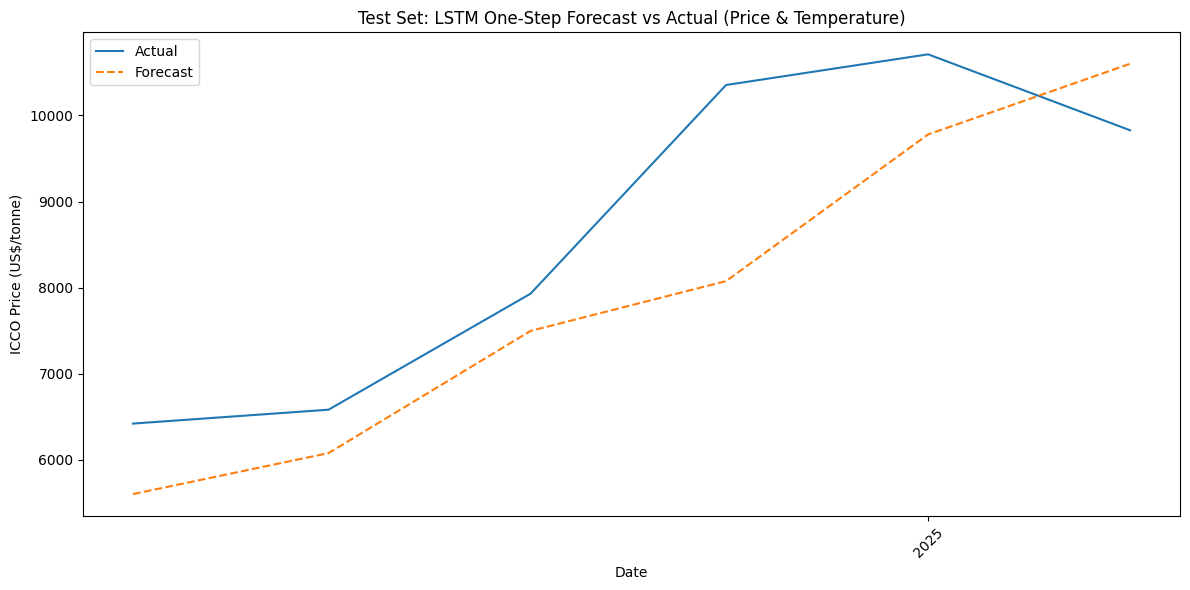

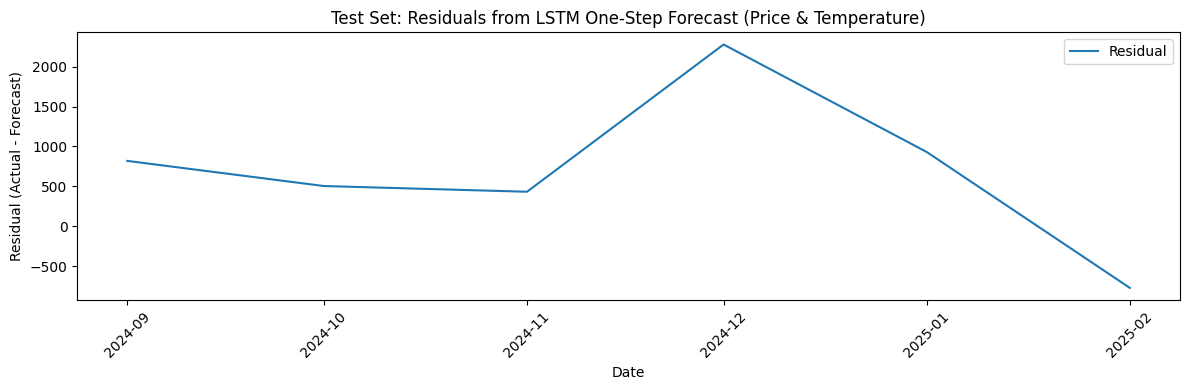

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import metrics

# Helper Functions (same as above)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i : i + seq_length]
        y_val = data[i + seq_length, 0]  # target is the price
        xs.append(x_seq)
        ys.append(y_val)
    return np.array(xs), np.array(ys).reshape(-1, 1)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Data Preparation & Scaling
df_tavg['YearMonth'] = pd.to_datetime(df_tavg['YearMonth'])
df_tavg.sort_values('YearMonth', inplace=True)
df_tavg = df_tavg.dropna()

# Create a 2D array: [price, temperature]
data_2d = df_tavg[['avg_price', 'MeanTAVG_lag6']].values

# Scale both features together.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_2d)

# Create Sequences and Train/Test Split
seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

m = len(df_tavg)
split_idx = m - 6 - seq_length  # last 6 months for testing.

train_X = X[:split_idx]
train_y = y[:split_idx]
test_X  = X[split_idx:]
test_y  = y[split_idx:]

print("Training sequences shape:", train_X.shape)
print("Test sequences shape:", test_X.shape)

# Define the LSTM Model (for 2 features)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 2  # Two features: price and temperature.
hidden_size = 30
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the Model on the Training Set
train_dataset = TensorDataset(torch.from_numpy(train_X).float(),
                              torch.from_numpy(train_y).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 300
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(train_dataset)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# Evaluate Forecasting Performance on the Test Set
model.eval()
with torch.no_grad():
    test_X_tensor = torch.from_numpy(test_X).float()
    test_predictions_tensor = model(test_X_tensor)

test_predictions = test_predictions_tensor.numpy().squeeze()
test_y_np = test_y.squeeze()

# Invert scaling for price only.
pred_2d = np.zeros((len(test_predictions), 2))
act_2d = np.zeros((len(test_y_np), 2))
pred_2d[:, 0] = test_predictions
act_2d[:, 0] = test_y_np

pred_inversed_2d = scaler.inverse_transform(pred_2d)
act_inversed_2d = scaler.inverse_transform(act_2d)
test_predictions_inversed = pred_inversed_2d[:, 0]
test_actual_inversed = act_inversed_2d[:, 0]

# Calculate Performance Metrics
mae = metrics.mean_absolute_error(test_actual_inversed, test_predictions_inversed)
rmse = np.sqrt(metrics.mean_squared_error(test_actual_inversed, test_predictions_inversed))
mape_value = mape(test_actual_inversed, test_predictions_inversed)

print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test MAPE:", mape_value)


# Plot the Test Forecasts and Residuals
forecast_dates = df_tavg['YearMonth'].iloc[split_idx + seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': test_actual_inversed,
    'Forecast': test_predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('Test Set: LSTM One-Step Forecast vs Actual (Price & Temperature)')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Test Set: Residuals from LSTM One-Step Forecast (Price & Temperature)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Price and total precipitation 44 months ago.

Training sequences shape: (326, 30, 2)
Test sequences shape: (6, 30, 2)
Epoch 20/300, Loss: 0.002303
Epoch 40/300, Loss: 0.001083
Epoch 60/300, Loss: 0.000735
Epoch 80/300, Loss: 0.000686
Epoch 100/300, Loss: 0.000537
Epoch 120/300, Loss: 0.000548
Epoch 140/300, Loss: 0.000477
Epoch 160/300, Loss: 0.000906
Epoch 180/300, Loss: 0.000403
Epoch 200/300, Loss: 0.000229
Epoch 220/300, Loss: 0.000221
Epoch 240/300, Loss: 0.000183
Epoch 260/300, Loss: 0.000179
Epoch 280/300, Loss: 0.000185
Epoch 300/300, Loss: 0.000176
Test MAE: 1259.7035333182407
Test RMSE: 1355.0277030805548
Test MAPE: 14.918855337824333


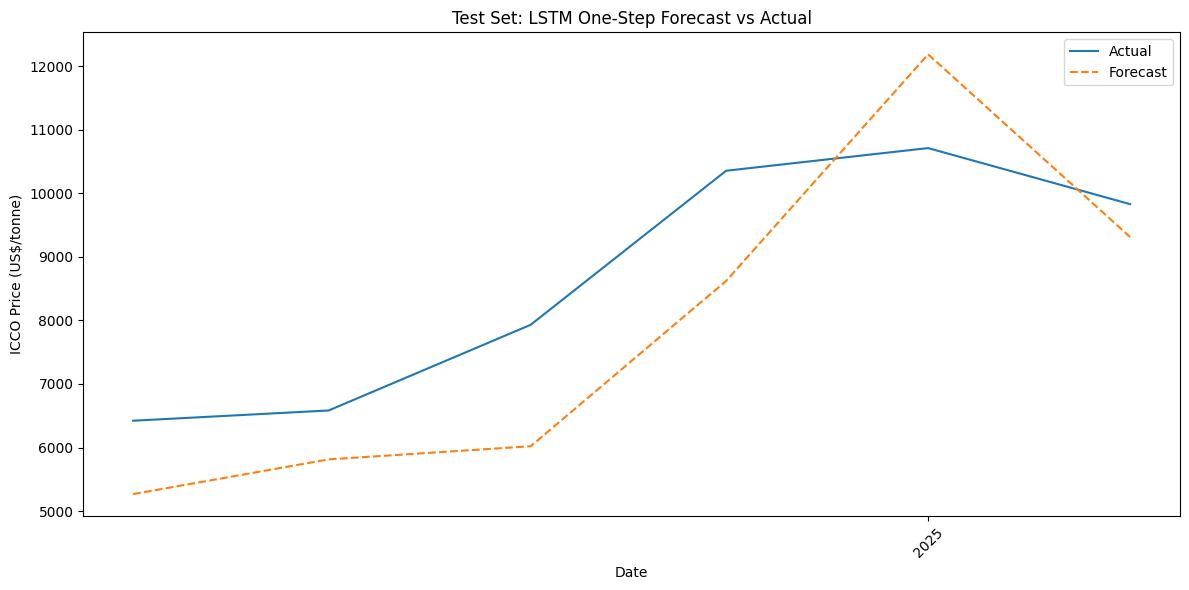

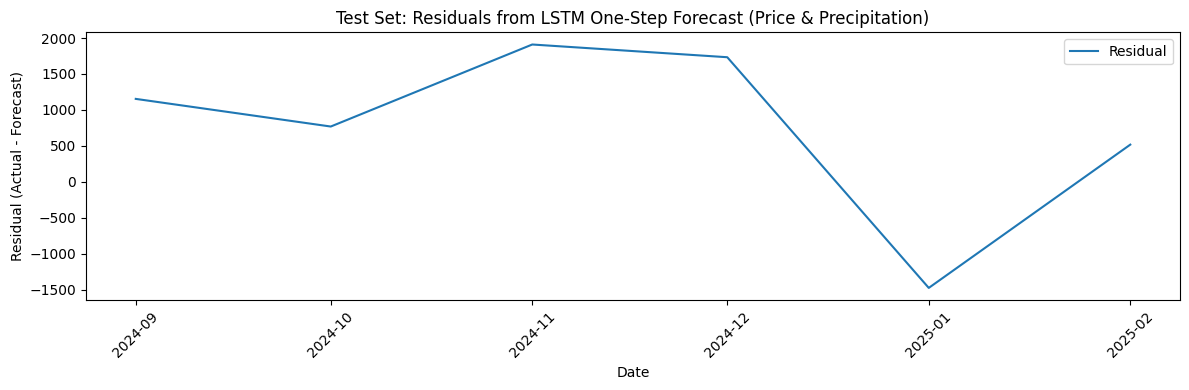

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
from sklearn import metrics


# Data Preparation & Scaling
# Make sure data is sorted by date.
df_prcp['YearMonth'] = pd.to_datetime(df_prcp['YearMonth'])
df_prcp.sort_values('YearMonth', inplace=True)
df_prcp = df_prcp.dropna()  # drop any rows with missing values

# Create a 2D array: [Price, Precipitation]
data_2d = df_prcp[['avg_price', 'TotalPRCP_lag44']].values

# Scale both features together
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_2d)

# Create Sequences for LSTM Forecasting
def create_sequences(data, seq_length):
    """
    data: numpy array of shape (num_samples, num_features)
    seq_length: number of time steps per sample
    Returns:
      X: array of shape (num_samples - seq_length, seq_length, num_features)
      y: array of shape (num_samples - seq_length, 1), using only the price (column 0) as target.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i : i + seq_length]    # shape (seq_length, 2)
        y_val = data[i + seq_length, 0]       # target is the price (first column)
        xs.append(x_seq)
        ys.append(y_val)
    return np.array(xs), np.array(ys).reshape(-1, 1)

seq_length = 30  # e.g., use the past 30 months to forecast the next month
X, y = create_sequences(data_scaled, seq_length)


# Split Data into Training and Test Sets
# Find the index in X (and y) such that the forecast date is in the last 6 months:
m = len(df_prcp)
# A sequence starting at index i forecasts row i+seq_length.
split_idx = m - 6 - seq_length

# Split the sequences:
train_X = X[:split_idx]
train_y = y[:split_idx]
test_X  = X[split_idx:]
test_y  = y[split_idx:]

print("Training sequences shape:", train_X.shape)
print("Test sequences shape:", test_X.shape)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        # Use the output from the last time step.
        out = self.fc(out[:, -1, :])
        return out

input_size = 2    # Two features: price and precipitation
hidden_size = 30
num_layers = 2
output_size = 1   # Forecast only the price

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the Model on the Training Set
# Create a DataLoader for training data.
train_dataset = TensorDataset(torch.from_numpy(train_X).float(),
                              torch.from_numpy(train_y).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 300
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(train_dataset)
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# Evaluate Forecasting Performance on the Test Set
model.eval()
with torch.no_grad():
    test_X_tensor = torch.from_numpy(test_X).float()
    test_predictions_tensor = model(test_X_tensor)

# Convert predictions and true values from tensors to numpy arrays.
test_predictions = test_predictions_tensor.numpy().squeeze()
test_y_np = test_y.squeeze()

# Because we scaled both columns together, reconstruct dummy arrays to invert scaling for price.
pred_2d = np.zeros((len(test_predictions), 2))
act_2d = np.zeros((len(test_y_np), 2))
pred_2d[:, 0] = test_predictions  # Only the first column is the price.
act_2d[:, 0] = test_y_np

# Invert scaling.
pred_inversed_2d = scaler.inverse_transform(pred_2d)
act_inversed_2d = scaler.inverse_transform(act_2d)
test_predictions_inversed = pred_inversed_2d[:, 0]
test_actual_inversed = act_inversed_2d[:, 0]

# Calculate performance metrics.
mae = metrics.mean_absolute_error(test_actual_inversed, test_predictions_inversed)
rmse = np.sqrt(metrics.mean_squared_error(test_actual_inversed, test_predictions_inversed))
mape_value = mape(test_actual_inversed, test_predictions_inversed)
print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test MAPE:", mape_value)

# Plot the Test Forecasts and Residuals
# Align the forecast dates. The forecast corresponding to sequence i is for df_prcp.iloc[i+seq_length].
forecast_dates = df_prcp['YearMonth'].iloc[split_idx + seq_length:].reset_index(drop=True)
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Actual': test_actual_inversed,
    'Forecast': test_predictions_inversed
})
results_df['Residual'] = results_df['Actual'] - results_df['Forecast']

# Plot Actual vs. Forecast.
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Forecast'], label='Forecast', linestyle='--')
plt.title('Test Set: LSTM One-Step Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('ICCO Price (US$/tonne)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Residuals.
plt.figure(figsize=(12, 4))
plt.plot(results_df['Date'], results_df['Residual'], label='Residual')
plt.title('Test Set: Residuals from LSTM One-Step Forecast (Price & Precipitation)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()